# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [23]:
import random

# If this cell does not work try running `pip install nbformat`

import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1086


## Group Number :31

## Student 1 
### Name :Yuqian Song
### ID :4630521

## Student 2
### Name : Akash Amalan
### ID : 4682505

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [24]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from numpy import interp
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.model_selection import learning_curve, StratifiedKFold
from scipy.spatial import KDTree
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from pca import pca
import re
from sklearn.preprocessing import LabelEncoder

How to run?

- Make a new conda env with ```conda create -n cyber_data python=3.9```
- In the env ```pip install -r requirements.txt```

### 1a. Data Preprocessing

In [25]:

def conv(row):
    #Define conversion rates
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}

    #Convert amount to EUR
    return row['amount'] / (currency_dict[row['currencycode']] * 100)


def preprocess(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering(create new feature)
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 'label']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted


## 1. Visualization task – 1 A4

### 1a. Plot visulations

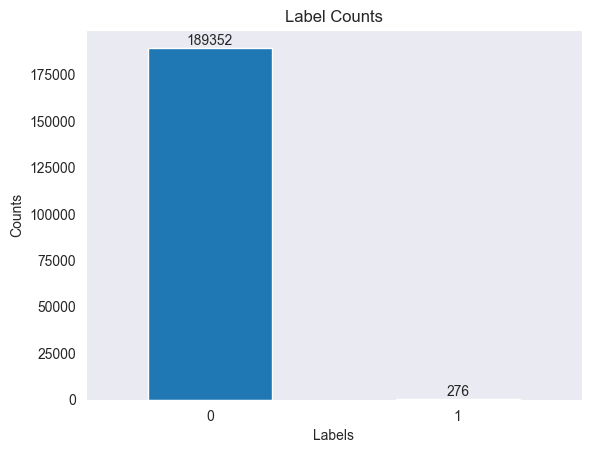

In [26]:
# Read the CSV file using pandas
pd_data = pd.read_csv('train_data.csv')
preprocessed = preprocess(pd_data)
data = preprocessed.to_numpy()


# Separate features and labels
features = data[:, :-1]
labels = data[:, -1]

# Count the unique labels and their occurrences
unique, counts = np.unique(labels, return_counts=True)

# Create a bar plot of label counts
ax = pd_data["label"].value_counts().plot(kind='bar', title='Label Counts', rot=0, grid=False)
ax.set_xlabel("Labels")
ax.set_ylabel("Counts")

# Add label counts to the bars
for container in ax.containers:
    ax.bar_label(container)


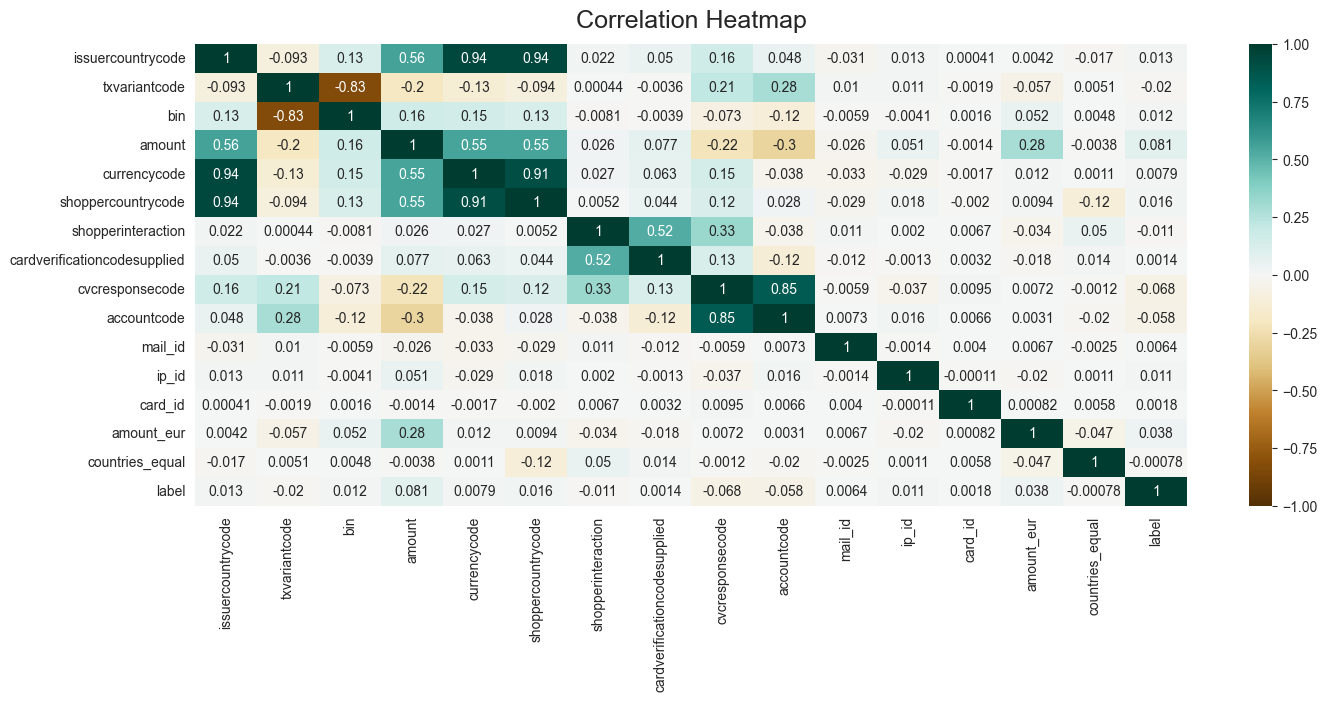

In [7]:

plt.figure(figsize=(16, 6))

# Create a correlation heatmap using seaborn
heatmap = sns.heatmap(preprocessed.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=12);



[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [16] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [16] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
     PC                       feature       loading  type
0   PC1                       card_id -9.616948e-01  best
1   PC2                       mail_id -7.327672e-01  best
2   PC3                         ip_id  7.720088e-01  best
3   PC4                        amo

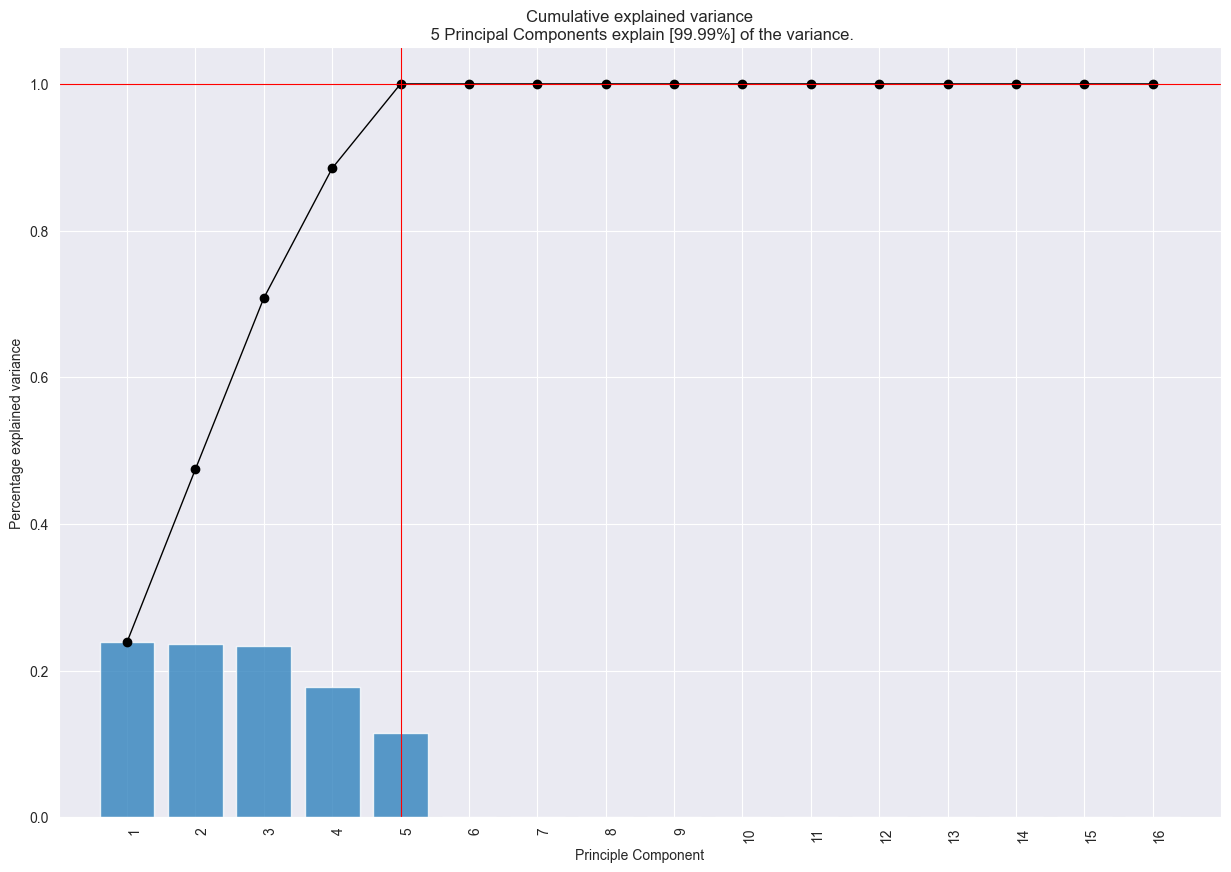

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 5 Principal Components explain [99.99%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 640x480 with 0 Axes>

In [8]:
# Create a copy of the preprocessed data
data_pca = preprocessed.copy(deep=True)

# Drop the 'label' column from the data
data_pca.drop(columns=['label'])
model = pca()

# Fit the model and transform the data
out = model.fit_transform(data_pca)

# Print the top features contributing to each principal component
print(out['topfeat'])

# Fit transform
model.plot()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

The first graph shows that there are 189352 labels for 0 and only 276 labels for 1, so this is a highly unbalanced dataset. Graph 2 shows a correlation map in which in identifies that features with similar colours are highly correlated shows as issuer_country_code with shoppercountry code, you can also see that amount is highly correlated with label suggesting that it is an important feature as one would expect. Graph 3 shows PCA and indicates that only 5 features are needed to explain most the variance(99%) in the data.This shows that reducing the dimensions is promising to mitigate the curse of dimensionality.

In [9]:
class SMOTE:
    def __init__(self, sampling_strategy=0.1, k=5, random_state=None):

        """
        Initializes Smote
        :param sampling_strategy:  fraction *  Samples of Majority
        :param N: The paper uses smote N%, I use a sampling strategy similar to that of IMBLEARN.
        :param k: Number of nearest Neighbours
        """
        self.sampling_strategy = sampling_strategy
        self.k = k
        self.random_state = random_state if random_state is not None else np.random.RandomState()

        if sampling_strategy > 1:
            raise Exception("sampling_strategy cannot be more than 1")

    def fit_resample(self, X, y):
        """
        Simililar to IMBLEARN method
        :param X: train_data
        :param y: train_labels
        :return: synthetic samples on top of original
        """
        # Identify the minority and majority class
        unique, counts = np.unique(y, return_counts=True)
        majority_class = unique[np.argmax(counts)]
        minority_class = unique[np.argmin(counts)]

        minority_samples = X[y == minority_class]
        majority_samples = X[y == majority_class]

        # Calculate the number of new synthetic samples(either using sampling strategy or without
        if isinstance(self.sampling_strategy, float):
            n_samples = int(len(majority_samples) * self.sampling_strategy) - len(minority_samples)
        else:
            n_samples = len(majority_samples)

        # Find k nearest neighbors of each minority sample (KDTree is efficient datastructure)
        kdtree = KDTree(minority_samples)

        # Generate synthetic samples
        synthetic_samples = []
        for i in range(n_samples):
            # Choose a random minority sample
            sample = minority_samples[self.random_state.randint(len(minority_samples))]

            # Choose a random one of its k nearest neighbors
            distances, neighbors = kdtree.query([sample], self.k)
            neighbor = minority_samples[self.random_state.choice(neighbors[0])]

            # Create a synthetic sample at a random point between the two as per slides
            synthetic_sample = sample + self.random_state.random() * (neighbor - sample)
            synthetic_samples.append(synthetic_sample)

        # Combine the original samples with the synthetic ones (attempt to get same number of samples in each class)

        X_res = np.vstack([X, np.array(synthetic_samples)])
        y_res = np.hstack([y, np.repeat(minority_class, n_samples)])

        return X_res, y_res

In [69]:
from sklearn.ensemble import StackingClassifier
class Trainer:

    def __init__(self,  X_train=None, y_train=None, X_test=None, y_test=None, random_state=30):
        """
        Initializes the Trainier with several machine learning models
        :param random_state: for determinism
        """
        self.random_state = random_state
        self.svc = svm.LinearSVC(random_state=self.random_state, dual=True)
        self.rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=self.random_state)
        self.lr = LogisticRegression(solver='newton-cholesky', C=100, n_jobs=-1, random_state=self.random_state)
        self.black_box = BaggingClassifier(estimator=self.lr, n_estimators=10, random_state=200, n_jobs=-1)

        self.white_box = self.lr
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test


    def set_black_box(self, model):
        self.black_box = model


    def train_black_box(self):
        """
        Trains the 'black_box' model (a BaggingClassifier) on provided training data.
        :param X_train: X_train
        :param y_train: y_train
        :return: trained model
        """
        self.black_box.fit(self.X_train, self.y_train)

    def get_block_box_auc(self):
        """
        Calculates and returns the ROC AUC score for the 'black_box' model
        :param X_test: X_test
        :param y_test: y_test
        :return: roc_auc_score
        """
        bagging_proba = self.black_box.predict_proba(self.X_test)
        return roc_auc_score(self.y_test, bagging_proba[:, 1])

    def get_auc(self):
        """
        Calculates and returns the ROC AUC scores for all 3 models
        :param X_test: X_test
        :param y_test: y_test
        :return: scores
        """

        y_proba_svc = self.svc._predict_proba_lr(self.X_test)
        y_probar_rfc = self.rfc.predict_proba(self.X_test)
        y_proba_lr = self.lr.predict_proba(self.X_test)

        fpr, tpr, _ = roc_curve(self.y_test, y_proba_svc[:, 1])
        roc_auc_svc = roc_auc_score(self.y_test, y_proba_svc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(self.y_test, y_probar_rfc[:, 1])
        roc_auc_rfc = roc_auc_score(self.y_test, y_probar_rfc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(self.y_test, y_proba_lr[:, 1])
        roc_auc_lr = roc_auc_score(self.y_test, y_proba_lr[:, 1])  # Calculate ROC AUC score

        return roc_auc_svc, roc_auc_rfc, roc_auc_lr

    def train_svc_rf_lr_classifiers(self):
        """
        Trains on all 3 classifiers
        :param X_train: X_train
        :param y_train: y_train
        :return: trained classifiers
        """

        #SVC
        self.svc.fit(self.X_train, self.y_train)
        print("Finished training on SVC")

        #Random Forest
        self.rfc.fit(self.X_train, self.y_train)
        print("Finished training on RFC")

        #LR
        self.lr.fit(self.X_train, self.y_train)
        print("Finished training on LR")



In [65]:
class Plotter:

    def __init__(self, X, y):
        """
        Initializes the plotter with train dataset and labels
        :param X: X
        :param y: y
        """
        self.X = X
        self.y = y

    def plot_learning_curve(self, estimator, title, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
        """
         Plots the learning curve for a specific model.
        :param estimator: estimator
        :param title: title
        :param X: X
        :param y: y
        :param cv: cv
        :param n_jobs: n_jobs
        :param train_sizes: train_sizes
        :return: learning_curve
        """
        plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Score")

        train_sizes, train_scores, test_scores = learning_curve(
            estimator, self.X, self.y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation AUC")

        plt.legend(loc="best")
        return plt

    def cross_validate_auc(self, title, model, cv=10):
        """
        Cross-validates the AUC score of a specific model, and also plots the learning curve.
        :param title: title
        :param model:model
        :param X:X
        :param y:y
        :param cv:cv
        :return: plots
        """
        self.plot_learning_curve(model, title, cv=cv, n_jobs=-1)
        plt.show()
        self.cross_validate_precision_recall(model)

    def cross_validate_precision_recall(self, model, splts=10):
        """
        Cross-validates the precision and recall of a specific model, and also plots the precision-recall curve
        :param model: model
        :param splts: splits
        :return: precision-recall curve
        """
        cv = StratifiedKFold(n_splits=splts)

        tprs = []
        aucs = []
        mean_recall = np.linspace(0, 1, 100)
        f1_scores = []

        fig, ax = plt.subplots()

        for i, (train, test) in enumerate(cv.split(self.X, self.y)):
            model.fit(self.X[train], self.y[train])
            probas = model.predict_proba(self.X[test])
            # Compute Precision-Recall and plot curve
            precision, recall, thresholds = precision_recall_curve(self.y[test], probas[:, 1])
            f1 = f1_score(self.y[test], model.predict(self.X[test]))
            f1_scores.append(f1)
            # Interpolate the precision-recall curve
            interp_precision = interp(mean_recall, recall[::-1], precision[::-1])
            interp_precision[0] = 1.0
            tprs.append(interp_precision)
            aucs.append(auc(mean_recall, interp_precision))

        mean_precision = np.mean(tprs, axis=0)
        mean_precision[-1] = 0.0
        mean_auc = auc(mean_recall, mean_precision)
        std_auc = np.std(aucs)

        ax.plot(mean_recall, mean_precision, color='b',
                label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tprs = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_precision + std_tprs, 1)
        tprs_lower = np.maximum(mean_precision - std_tprs, 0)
        ax.fill_between(mean_recall, tprs_lower, tprs_upper, color='grey', alpha=.2)

        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
               title="Precision-Recall Curve")
        ax.legend(loc="lower right")
        plt.show()

        # Print the average F1 score
        print('Average F1 score: ', np.mean(f1_scores))


def plot_sklearn_roc_curve( y_real, y_pred, title):
    """
    Plots the ROC curve for a specific model
    :param y_real: y_real
    :param y_pred: y_pred
    :param title: title of plot
    :return:
    """
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_auc = roc_auc_score(y_real, y_pred)  # Calculate ROC AUC score

    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5, 5)
    plt.plot([0, 1], [0, 1], color='g')

    plt.title(title)
    plt.text(0.6, 0.2, f"AUC = {roc_auc:.4f}", fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    plt.show()


def plot( models, X_test, y_test ):
    """
    Plots the Roc curve for all 3 models
    :param models:  models       #SVM, Random Forest, Logisitc Regression
    :param X_test: X_test
    :param y_test: y_test
    :return: plots
    """

    y_proba = models[0]._predict_proba_lr(X_test)
    y_probarfc = models[1].predict_proba(X_test)
    y_probalr = models[2].predict_proba(X_test)

    plot_sklearn_roc_curve(y_test, y_proba[:, 1], "SVM")
    plot_sklearn_roc_curve(y_test, y_probarfc[:, 1], "Random Forest")
    plot_sklearn_roc_curve(y_test, y_probalr[:, 1], "Logistic Regression")

    plt.figure(figsize=(10, 6))
    plt.suptitle("ROC Curve Analysis", fontsize=16)
    plt.show()


## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

Finished processing data


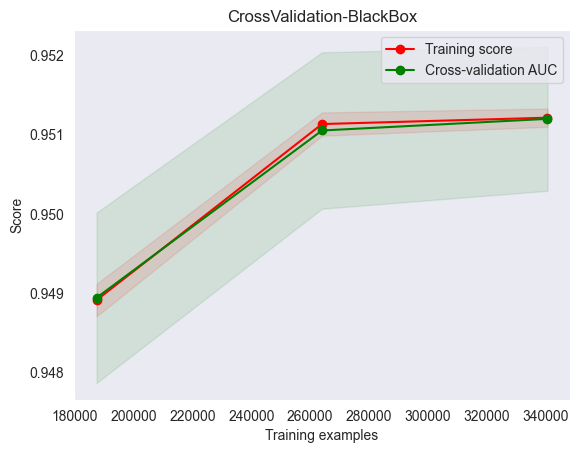

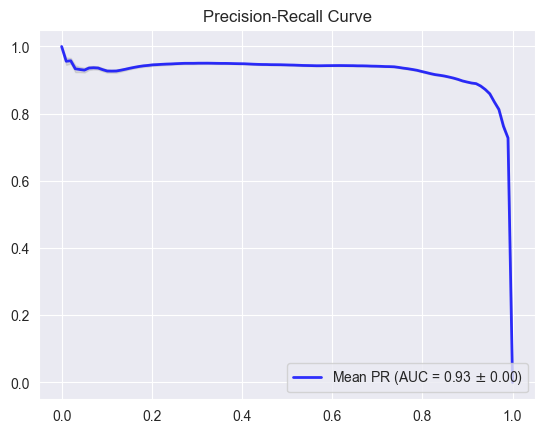

Average F1 score:  0.901967858464951


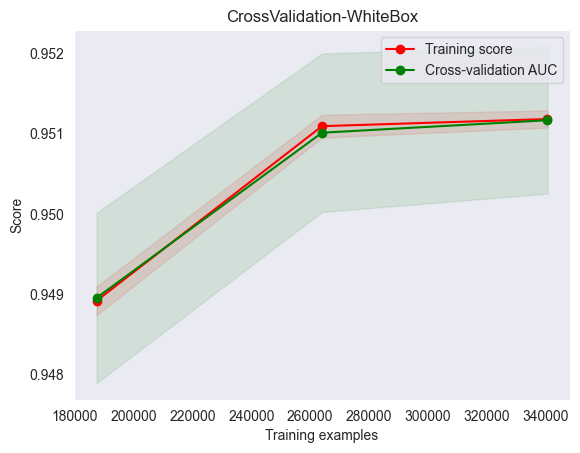

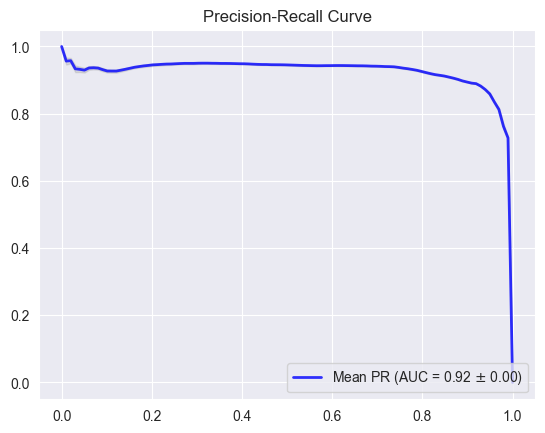

Average F1 score:  0.9017631875299674


In [12]:
from sklearn.decomposition import PCA

data_transformed = preprocessed.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler()),  ('pca', PCA(0.99))])
Xt = pipe.fit_transform(X, y)
random_state = 200

oversample = SMOTE(sampling_strategy=0.999)
X_res, y_res = oversample.fit_resample(Xt, y)

print("Finished processing data")
p = Plotter(X_res, y_res)
t= Trainer()
p.cross_validate_auc('CrossValidation-BlackBox', t.black_box)
p.cross_validate_auc('CrossValidation-WhiteBox', t.white_box)


### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

**The main data processing methods were the following:**
  -  First convert the currency rates to actual amounts
  - Fill missing values with reasonable values(look at preprocess function)
  - We also created some new featurees: countries_equal if shoppercountry code is equal to issuer coutnry code
  - Then we used ordinal encoding on all of the features

**Before applying any learning algorithms, we did 2 main things:**
  - Scale features - this is needed for algorithms that rely on distance or that do not estimate convariance matrix like svm
  - Apply PCA - from the pca plot in the visualizations we found that 99% of variance was explained by just 4 components, therefore pca was applied to minimize the dimensions to mitigate the effect of curse of dimensionality

**The 2 learning algorithms were:**
 - black-box : bagging Classifier with svm
 - white-box : logistic regression

     - Explanation: Bagging ensemble method was chosen to decrease the variance in an attempt to combat overfitting, svm was the best performing classifier therefore it was used the base classifer for bagging.
    Logistic regression perfrormed pretty well, therefore it was chosen as the white box model

**Performance criteria:**
   - Explanation: Naturally, since we are dealing with an inbalanced dataset, we cannot use accuracy instead we looked at the auc score (area under roc curve), f1 score. Both of these measure how the ratio of precision and recall giving a good idea of whether there are  too many FPs due to imbalanced data.

**Visualizations:**
   - What best to visualize the auc and f1 score other than roc curve and precision and recall curve. The figures show that both the model achieve an auc score of 0.951 with a similar precision-recall curve


['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode', 'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 'label']
Feature Importance
Feature 0: issuercountrycode Importance: 2.03006
Feature 1: txvariantcode Importance: 1.87417
Feature 2: bin Importance: -8.24163
Feature 3: amount Importance: 10.18815
Feature 4: currencycode Importance: 1.50856
Feature 5: shoppercountrycode Importance: -1.39729
Feature 6: shopperinteraction Importance: 1.42783
Feature 7: cardverificationcodesupplied Importance: -0.53265
Feature 8: cvcresponsecode Importance: -3.36352
Feature 9: accountcode Importance: -51.28982
Feature 10: mail_id Importance: 7.10018
Feature 11: ip_id Importance: 2.39077
Feature 12: card_id Importance: 2.50705


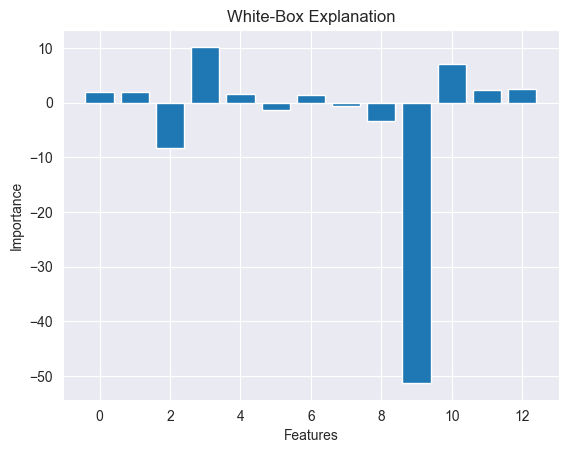

In [13]:
from matplotlib import pyplot

# Get the feature importances
importances = t.white_box.coef_[0]

data_transformed = preprocessed
# Match the feature names with the importances
features = [col for col in data_transformed.columns]


print('Feature Importance')
for i, v in enumerate(importances):
    print('Feature %d: %s Importance: %.5f' % (i, features[i],v))

pyplot.title("White-Box Explanation")
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.xlabel('Features')
pyplot.ylabel('Importance')
pyplot.show()


**White-box decision function explanation:**

From the above graph, it can be seen that the trained white box model logistic Regression considers 2 main features as very important feature 3(amount) and feature 10(mail_id). Feature 3 has an importance of 10.2 and feature 10 has an importance of  7.15. Note that these feauture importance are simply the weights of individual features, under the assumption that the decision boundary is linear we can use their weights to explain what the model has learned. In this case, it thinks that a high amount and a subset of mail_ids makes a transaction fraudulent. Logically speaking, this makes sense as amount and where the transaction is being transferred would be the first think I check if I have to manually check for fraudulent transactions.

## 5. Bonus task – 1 A4

t### 5a. Provide code and report below

We have already done some feature aggregation in data preprocessing and applied pca in the preprocessing stages of this notebook. We tried creating  countries_equal by seeing whether shoppercountrycode is equal to the issuercounrtycode. The main idea behind this was that if both shoppercountry and issuercountrycode were different it might be fraudulent. However, after applying pca, this feature was not considered meaning that it was not important. However, to consider if it would have made a difference lets classify without pca and those features:


Finished processing data


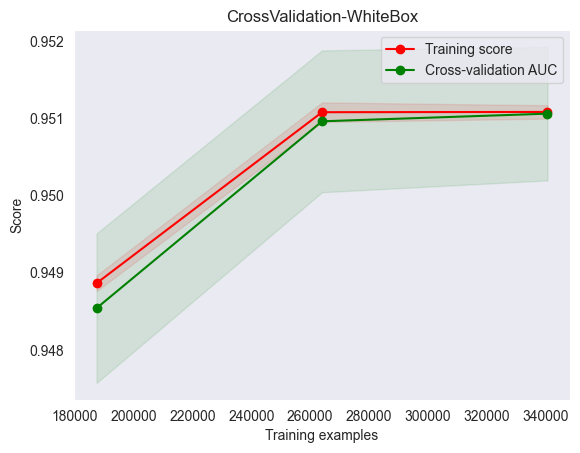

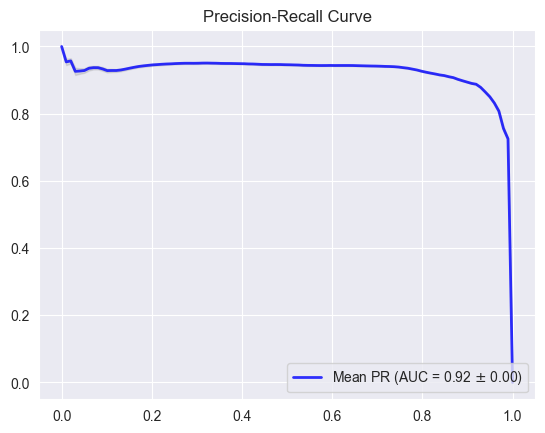

Average F1 score:  0.8996691653354747


In [14]:
def preprocess_train(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'label']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted

pd_data = pd.read_csv('train_data.csv')
preprocessed = preprocess_train(pd_data)
data = preprocessed.to_numpy()
X = data[:, :-1]
y = data[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)
random_state = 200

oversample = SMOTE(sampling_strategy=0.999)
X_res, y_res = oversample.fit_resample(Xt, y)

print("Finished processing data")
p = Plotter(X_res, y_res)
t= Trainer()
p.cross_validate_auc('CrossValidation-WhiteBox', t.white_box)


It seems both PCA and AUC score were not affected by both PCA and the new feature, that said the average f1 score did slightly decrease but not enough to validate that PCA and the new feature made any difference, I will now try some new aggregations


Finished processing data


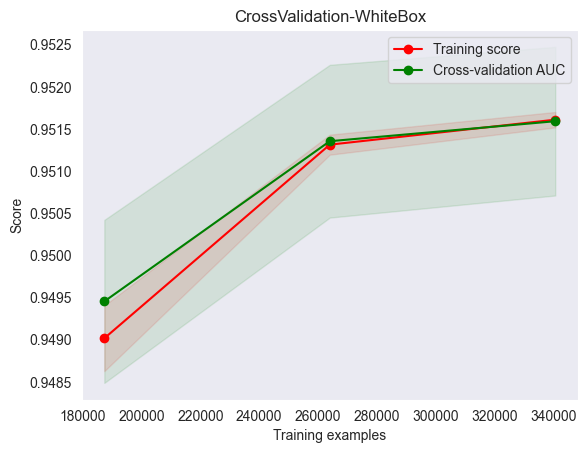

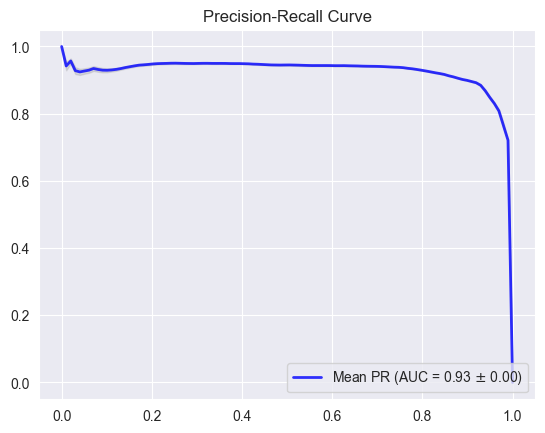

Average F1 score:  0.9006277706412205


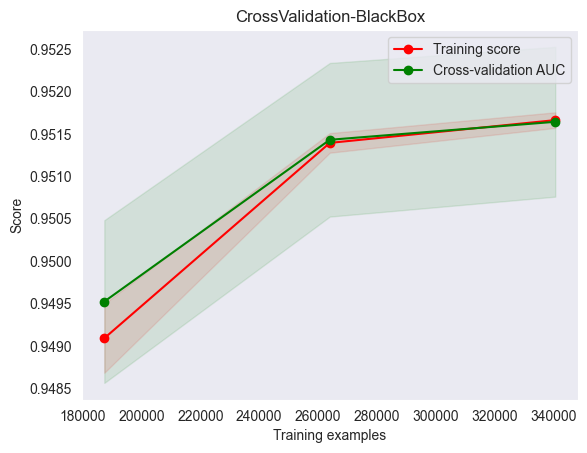

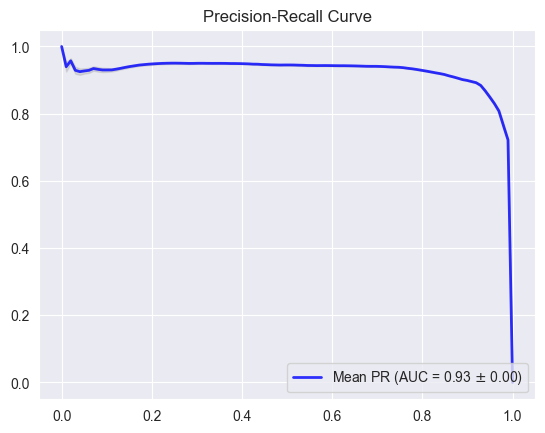

Average F1 score:  0.9007000612128472


In [15]:
def preprocess_train(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'


    df['issuercountrycode_count'] = df.groupby('issuercountrycode')['issuercountrycode'].transform('count')

    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'issuercountrycode_count', 'label']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted

pd_data = pd.read_csv('train_data.csv')
preprocessed = preprocess(pd_data)
data = preprocessed.to_numpy()
X = data[:, :-1]
y = data[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)


oversample = SMOTE(sampling_strategy=0.999)
X_res, y_res = oversample.fit_resample(Xt, y)

print("Finished processing data")
p = Plotter(X_res, y_res)
t= Trainer()
p.cross_validate_auc('CrossValidation-WhiteBox', t.white_box)
p.cross_validate_auc('CrossValidation-BlackBox', t.black_box)

Well adding that new feature did not improve the score much. Instead of doing this for every single feature I add, I will explain the general features and motivation behind it:

  - card_usage_frequency (How often card is used)
  - Total amount spend by card
  -  unique cards per issues ( maybe the number of unqiue cards has a relation to fraud?)
  - mean amount per _issuer ( this is a statistical feature)
  - Finish off with PCA ( Dimensionality reduction since we added more feature)

In [ ]:
def preprocess_train(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering(create new feature)
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'


    df['issuercountrycode_count'] = df.groupby('issuercountrycode')['issuercountrycode'].transform('count')

    df['mean_amount_per_issuer'] = df.groupby('issuercountrycode')['amount'].transform('mean')
    df['unique_cards_per_issuer'] = df.groupby('issuercountrycode')['card_id'].transform('nunique')
    df['card_usage_frequency'] = df.groupby('card_id')['card_id'].transform('count')
    df['total_amount_by_card'] = df.groupby('card_id')['amount'].transform('sum')
    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 'total_amount_by_card',
                       'mean_amount_per_issuer', 'unique_cards_per_issuer',
                       'card_usage_frequency','total_amount_by_card','label']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted

pd_data = pd.read_csv('train_data.csv')
preprocessed = preprocess_train(pd_data)
data = preprocessed.to_numpy()
X = data[:, :-1]
y = data[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler())])
Xt = pipe.fit_transform(X, y)


oversample = SMOTE(sampling_strategy=0.999)
X_res, y_res = oversample.fit_resample(Xt, y)

print("Finished processing data")
p = Plotter(X_res, y_res)
t= Trainer()
# p.cross_validate_auc('CrossValidation-WhiteBox', t.white_box, cv = 20)
p.cross_validate_auc('CrossValidation-BlackBox', t.black_box, cv = 20)

Finished processing data


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\akash\anaconda3\envs\cyber_data\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\joblib\externals\loky\process_executor.py", line 563, in run
    self.process_result_item(result_item)
  File "C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\joblib\externals\loky\process_executor.py", line 706, in process_result_item
    executor._adjust_process_count()
  File "C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\joblib\externals\loky\process_executor.py", line 1111, in _adjust_process_count
    p.start()
  File "C:\Users\akash\anacon

As you see from the results, the aggregated features increased the mean AUC to 0.93 and also the auc score increased to 0.9530

**KAGGLE**

In [61]:

def preprocess_test(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering(create new feature)
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'


    df['issuercountrycode_count'] = df.groupby('issuercountrycode')['issuercountrycode'].transform('count')

    df['mean_amount_per_issuer'] = df.groupby('issuercountrycode')['amount'].transform('mean')
    df['unique_cards_per_issuer'] = df.groupby('issuercountrycode')['card_id'].transform('nunique')
    df['card_usage_frequency'] = df.groupby('card_id')['card_id'].transform('count')
    df['total_amount_by_card'] = df.groupby('card_id')['amount'].transform('sum')
    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 'total_amount_by_card',
                       'mean_amount_per_issuer', 'unique_cards_per_issuer',
                       'card_usage_frequency','total_amount_by_card']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted


pd_data = pd.read_csv('test_data.csv')
preprocessed = preprocess_test(pd_data)

Xt = pipe.fit_transform(preprocessed)

predictions = t.black_box.predict(Xt)
result = pd.DataFrame({'Id': pd_data.iloc[:, 0], 'Predicted': predictions})
result.to_csv('answer.csv', index=False)